In [1]:
import dgl
import dgl.function as fn
import torch as th
import torch.nn as nn
import torch.nn.functional as F
from dgl import DGLGraph

Using backend: pytorch


https://mp.weixin.qq.com/s?__biz=MzI2MDE5MTQxNg%3D%3D&idx=1&mid=2649695390&scene=21&sn=ad628f54c97968d6fff55907c47cb77e#wechat_redirect

定义 GCN 的 message 函数和 reduce 函数， message 函数用于发送节点的Embedding，reduce 函数用来对收到的 Embedding 进行聚合

In [2]:
# 在这里，每个节点发送Embedding的时候不需要任何处理
#所以可以通过内置的copy_scr实现，out='m'表示发送到目的节点后目的节点的mailbox用m来标识这个消息是源节点的Embedding。
gcn_msg=fn.copy_src(src="h",out="m")
gcn_reduce=fn.sum(msg="m",out="h")#聚合邻居节点的特征

定义一个应用于节点的node UDF(user defined function)，<br>
即定义一个全连接层来对中间节点表示 $\hat h_i$ 进行线性变换<br>
然后在利用非线性函数f进行计算:$h_u^{new}=f(W_u\hat h_u)$

In [3]:
#定义节点的UDF apply_nodes  他是一个完全连接层
class NodeApplyModule(nn.Module):
    #初始化
    def __init__(self,in_feats,out_feats,activation):
        super(NodeApplyModule,self).__init__()
        self.linear=nn.Linear(in_feats,out_feats)
        self.activation=activation
    #前向传播
    def forward(self,node):
        h=self.linear(node.data["h"])
        if self.activation is not None:
            h=self.activation(h)
        return {"h":h}

定义GCN的Embedding更新层，以实现在所有节点上进行消息传递，并利用NodeApplyMoudle 对节点新进行计算更新

In [4]:
#定义GCN模块  GCN模块的本质是在所有节点上执行消息传递  然后再调用NOdeApplyModule全连接层
class GCN(nn.Module):
    #初始化
    def __init__(self,in_feats,out_feats,activation):
        super(GCN,self).__init__()
        #调用全连接层模块
        self.apply_mod=NodeApplyModule(in_feats,out_feats,activation)
    #前向传播
    def forward(self,g,feature):
        g.ndata["h"]=feature#feature应该对应的整个图的特征矩阵
        g.update_all(gcn_msg,gcn_reduce)
        g.apply_nodes(func=self.apply_mod)#将更新操作应用到节点上
        
        return g.ndata.pop("h")

定义了一个包含两个GCN层的图神经网络分类器。向该分类器输入1433的训练样本一获得该样本所属的类别编号，共7类

In [5]:
#利用cora数据集搭建网络然后训练
class Net(nn.Module):
    #初始化网络参数
    def __init__(self):
        super(Net,self).__init__()
        self.gcn1=GCN(1433,16,F.relu)#第一层GCN
        self.gcn2=GCN(16,7,None)
    #前向传播
    def forward(self,g,features):
        x=self.gcn1(g,features)
        x=self.gcn2(g,x)
        return x
net=Net()
net

Net(
  (gcn1): GCN(
    (apply_mod): NodeApplyModule(
      (linear): Linear(in_features=1433, out_features=16, bias=True)
    )
  )
  (gcn2): GCN(
    (apply_mod): NodeApplyModule(
      (linear): Linear(in_features=16, out_features=7, bias=True)
    )
  )
)

数据集

In [6]:
#使用DGL内置模块加载cora数据集
from dgl.data import citation_graph as citegrh
import networkx as nx
def load_cora_data():
    data = citegrh.load_cora()#加载数据集
    features=th. FloatTensor(data.features)#特征向量  张量的形式
    labels=th.LongTensor(data.labels)#所属类别
    train_mask=th.BoolTensor(data.train_mask)#那些参与训练
    test_mask=th.BoolTensor(data.test_mask)#哪些是测试集
    g=data.graph
    g.remove_edges_from(nx.selfloop_edges(g))#删除自循环的边
    g = DGLGraph(g)
    g.add_edges(g.nodes(), g.nodes())
    return g, features, labels, train_mask, test_mask
 
g, features, labels, train_mask, test_mask=load_cora_data()


Loading from cache failed, re-processing.
Finished data loading and preprocessing.
  NumNodes: 2708
  NumEdges: 10556
  NumFeats: 1433
  NumClasses: 7
  NumTrainingSamples: 140
  NumValidationSamples: 500
  NumTestSamples: 1000
Done saving data into cached files.


/root/anaconda3/lib/python3.7/site-packages/dgl/data/utils.py:285: UserWarning: Property dataset.feat will be deprecated, please use g.ndata['feat'] instead.
  warnings.warn('Property {} will be deprecated, please use {} instead.'.format(old, new))
/root/anaconda3/lib/python3.7/site-packages/dgl/data/utils.py:285: UserWarning: Property dataset.label will be deprecated, please use g.ndata['label'] instead.
  warnings.warn('Property {} will be deprecated, please use {} instead.'.format(old, new))
/root/anaconda3/lib/python3.7/site-packages/dgl/data/utils.py:285: UserWarning: Property dataset.train_mask will be deprecated, please use g.ndata['train_mask'] instead.
  warnings.warn('Property {} will be deprecated, please use {} instead.'.format(old, new))
/root/anaconda3/lib/python3.7/site-packages/dgl/data/utils.py:285: UserWarning: Property dataset.test_mask will be deprecated, please use g.ndata['test_mask'] instead.
  warnings.warn('Property {} will be deprecated, please use {} instead.

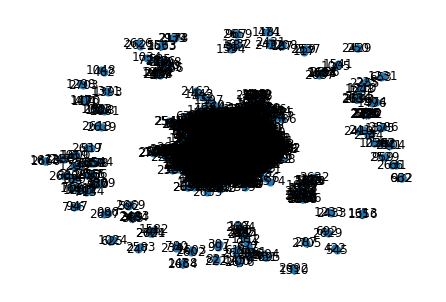

In [7]:
import matplotlib.pyplot as plt
nx.draw(g.to_networkx(),node_size=50,with_labels=True)
plt.show()

In [8]:
#测试模型
def evaluate(model, g, features, labels, mask):
    model.eval()#会通知所有图层您处于评估模式
    with th.no_grad():
        logits = model(g, features)
        logits = logits[mask]
        labels = labels[mask]
        _, indices = th.max(logits, dim=1)
        correct = th.sum(indices == labels)
        return correct.item() * 1.0 / len(labels)


In [9]:

#训练网络
import time
import numpy as np
g, features, labels, train_mask, test_mask = load_cora_data()

#定义优化器
optimizer=th.optim.Adam(net.parameters(),lr=1e-3)
dur=[]#时间
for epoch in range(100):
    print(epoch)
    if epoch>=3:
        t0=time.time()
    net.train()
    logits = net(g, features)
    logp = F.log_softmax(logits, 1)
    loss = F.nll_loss(logp[train_mask], labels[train_mask])
 
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
 
    if epoch >=3:
        dur.append(time.time() - t0)
 
    acc = evaluate(net, g, features, labels, test_mask)
    print("Epoch {:05d} | Loss {:.4f} | Test Acc {:.4f} | Time(s) {:.4f}".format(
            epoch, loss.item(), acc, np.mean(dur)))


Loading from cache failed, re-processing.
Finished data loading and preprocessing.
  NumNodes: 2708
  NumEdges: 10556
  NumFeats: 1433
  NumClasses: 7
  NumTrainingSamples: 140
  NumValidationSamples: 500
  NumTestSamples: 1000
Done saving data into cached files.
0
Epoch 00000 | Loss 1.9615 | Test Acc 0.1050 | Time(s) nan
1
Epoch 00001 | Loss 1.9425 | Test Acc 0.1380 | Time(s) nan
2
Epoch 00002 | Loss 1.9244 | Test Acc 0.1570 | Time(s) nan
3


/root/anaconda3/lib/python3.7/site-packages/dgl/data/utils.py:285: UserWarning: Property dataset.feat will be deprecated, please use g.ndata['feat'] instead.
  warnings.warn('Property {} will be deprecated, please use {} instead.'.format(old, new))
/root/anaconda3/lib/python3.7/site-packages/dgl/data/utils.py:285: UserWarning: Property dataset.label will be deprecated, please use g.ndata['label'] instead.
  warnings.warn('Property {} will be deprecated, please use {} instead.'.format(old, new))
/root/anaconda3/lib/python3.7/site-packages/dgl/data/utils.py:285: UserWarning: Property dataset.train_mask will be deprecated, please use g.ndata['train_mask'] instead.
  warnings.warn('Property {} will be deprecated, please use {} instead.'.format(old, new))
/root/anaconda3/lib/python3.7/site-packages/dgl/data/utils.py:285: UserWarning: Property dataset.test_mask will be deprecated, please use g.ndata['test_mask'] instead.
  warnings.warn('Property {} will be deprecated, please use {} instead.

Epoch 00003 | Loss 1.9069 | Test Acc 0.1800 | Time(s) 0.0142
4
Epoch 00004 | Loss 1.8877 | Test Acc 0.1990 | Time(s) 0.0127
5
Epoch 00005 | Loss 1.8678 | Test Acc 0.2650 | Time(s) 0.0121
6
Epoch 00006 | Loss 1.8476 | Test Acc 0.3030 | Time(s) 0.0124
7
Epoch 00007 | Loss 1.8273 | Test Acc 0.3170 | Time(s) 0.0119
8
Epoch 00008 | Loss 1.8070 | Test Acc 0.3430 | Time(s) 0.0116
9
Epoch 00009 | Loss 1.7859 | Test Acc 0.3640 | Time(s) 0.0117
10
Epoch 00010 | Loss 1.7642 | Test Acc 0.3840 | Time(s) 0.0115
11
Epoch 00011 | Loss 1.7429 | Test Acc 0.4020 | Time(s) 0.0113
12
Epoch 00012 | Loss 1.7218 | Test Acc 0.4260 | Time(s) 0.0115
13
Epoch 00013 | Loss 1.7007 | Test Acc 0.4430 | Time(s) 0.0113
14
Epoch 00014 | Loss 1.6792 | Test Acc 0.4670 | Time(s) 0.0112
15
Epoch 00015 | Loss 1.6581 | Test Acc 0.4880 | Time(s) 0.0113
16
Epoch 00016 | Loss 1.6376 | Test Acc 0.5100 | Time(s) 0.0112
17
Epoch 00017 | Loss 1.6174 | Test Acc 0.5270 | Time(s) 0.0111
18
Epoch 00018 | Loss 1.5977 | Test Acc 0.5350 | 